In [1]:
import albumentations as A
import numpy as np
import os
import random
import sys

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch import nn, Tensor, IntTensor, LongTensor, FloatTensor

from functools import partial
from omegaconf import DictConfig, OmegaConf
from tqdm.notebook import tqdm
from typing import Any, Callable, Dict, Iterable, List, Tuple

In [2]:
import cv2
import PIL
import kornia

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
BASE_DIR = '/home/dmitry/projects/dfdc'
SRC_DIR = os.path.join(BASE_DIR, 'src')
VID_DIR = '/media/dmitry/data/dfdc-videos/dfdc_train_part_38'

In [5]:
sys.path.insert(0, f'/home/{os.environ["USER"]}/projects/dfdc/vendors/Pytorch_Retinaface')
from data import cfg_mnet, cfg_re50
from layers.functions.prior_box import PriorBox
from models.retinaface import RetinaFace
from utils.nms.py_cpu_nms import py_cpu_nms

In [6]:
sys.path.insert(0, SRC_DIR)
sys.path.insert(0, './utils')
from detectors.retinaface import init_detector, prepare_imgs, decode_batch
from video import read_frames_cv2

In [7]:
from visualise import show_images

In [8]:
conf = OmegaConf.load('../config/predict.yaml')

In [9]:
device = torch.device('cuda')

In [10]:
def merge_detector_cfg(conf: DictConfig) -> Dict[str, any]:
    cfg = cfg_mnet if conf.encoder == 'mnet' else cfg_re50
    for key in "batch_size, score_thresh, nms_thresh, top_k, keep_top_k".split(", "):
        if key not in conf or conf[key] is None:
            raise AttributeError("Missing {} in detector config".format(key))
    cfg = {**cfg, **conf}
    return cfg

In [11]:
face_det_conf = merge_detector_cfg(conf['face-detection'])
detector = init_detector(
    face_det_conf, 
    face_det_conf['weights'], 
    device
).to(device)
# detect_fn = partial(detect, model=detector, cfg=face_det_conf, device=device)

Loading pretrained model from /home/dmitry/projects/dfdc/data/weights/mobilenet0.25_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300


In [12]:
files = os.listdir(VID_DIR)

In [13]:
path = os.path.join(VID_DIR, files[12])
sample_np = read_frames_cv2(path, 30)
sample_orig = torch.from_numpy(sample_np).to(device)

D, H, W, C = sample_orig.shape

In [14]:
sample, scale = prepare_imgs(sample_orig)
sample.shape, scale

(torch.Size([30, 3, 1080, 1920]), tensor([1920, 1080, 1920, 1080]))

In [17]:
D, C, H, W = sample.shape
priorbox = PriorBox(face_det_conf, image_size=(H, W))
priors = priorbox.forward().to(device)
scale = scale.to(device)

In [18]:
with torch.no_grad():
    locations, confidence, landmarks = detector(sample)

In [19]:
def postproc_frame_torch(boxes: Tensor, scores: Tensor, conf: Dict[str, Any]) -> Tensor:
    idxs = (scores > conf['score_thresh']).nonzero().squeeze_(1)
    if idxs.size(0):
        boxes = boxes[idxs]
        scores = scores[idxs]

        # keep top-K before NMS
        top_k = conf['top_k']
        scores, idxs = scores.sort(descending=True)
        scores, idxs = scores[:top_k], idxs[:top_k]
        boxes = boxes[idxs]

        # do NMS
        nms_thresh = conf['nms_thresh']
        keep_top_k = conf['keep_top_k']
        keep = torchvision.ops.nms(boxes, scores, nms_thresh)
        boxes = boxes[keep][:keep_top_k]
        scores = scores[keep][:keep_top_k]
        scores = scores.unsqueeze_(1)
        return torch.cat([boxes, scores], dim=1)
    else:
        return torch.empty(0, 5, device=boxes.device, dtype=torch.float32)


def postproc_detections(locations: Tensor, confidence: Tensor, priors: Tensor, 
                        scale: Tensor, conf: Dict[str, any], resize=1) -> List[Tensor]:
    boxes = decode_batch(locations, priors, conf['variance'])
    boxes = boxes * scale / resize
    scores = confidence[:, :, 1]
    N = boxes.size(0)
    out = []
    for f in range(N):
        boxes_f = postproc_frame_torch(boxes[f], scores[f], conf)
        out.append(boxes_f)
    return out

In [20]:
dets = postproc_detections(locations, confidence, priors, scale, face_det_conf)

In [21]:
resize = 1
boxes = decode_batch(locations, priors, face_det_conf['variance'])
boxes = boxes * scale / resize

In [22]:
def calc_axis_torch(c0: IntTensor, c1: IntTensor, pad: IntTensor, 
                    cmax: int) -> Tuple[IntTensor, ...]:
    c0 = max(0, c0 - pad)
    c1 = min(cmax, c1 + pad)
    return c0, c1, c1 - c0


def expand_bbox_torch(bbox: FloatTensor, pct: float) -> FloatTensor:
    bbox = bbox.clone().detach()
    bbox[:2] *= 1 - pct
    bbox[2:] *= 1 + pct
    return bbox


def fix_coords_torch(bbox: FloatTensor, img_width: int, img_height: int) -> Tuple[FloatTensor, ...]:    
    x0, y0, x1, y1 = bbox.int()
    x0.clamp_min_(0)
    y0.clamp_min_(0)
    x1.clamp_max_(img_width)
    y1.clamp_max_(img_height)
    return x0, y0, x1, y1


def crop_square_torch(img: IntTensor, bbox: FloatTensor, pad_pct=0.05) -> IntTensor:
    C, H, W = img.shape
    if pad_pct > 0:
        bbox = expand_bbox_torch(bbox, pad_pct)
    x0, y0, x1, y1 = fix_coords_torch(bbox, W, H)
    w, h = x1 - x0, y1 - y0
    if w > h:
        pad = (w - h) // 2
        y0, y1, h = calc_axis_torch(y0, y1, pad, H)
    elif h > w:
        pad = (h - w) // 2
        x0, x1, w = calc_axis_torch(x0, x1, pad, W)
    size = min(w, h)
    face = img[:, y0:y1, x0:x1][:, :size, :size]
    return face

In [23]:
sample.shape, len(dets)

(torch.Size([30, 3, 1080, 1920]), 30)

In [30]:
f = -1

torch.Size([3, 334, 334])


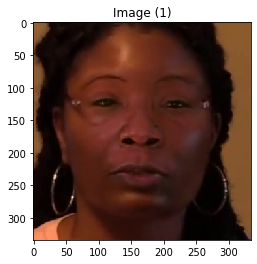

In [32]:
f += 1
crop = crop_square_torch(sample_orig[f].permute(2, 0, 1), dets[f][0, :4])
print(crop.shape)
crop1 = crop.cpu().numpy().transpose(1, 2, 0)
show_images(crop1[None, :])

In [47]:
from dataset.transforms import ResizeTensor, SpatialGradFilter

In [41]:
resize = ResizeTensor(256, normalize=True)

In [44]:
crop1 = resize(crop)

In [46]:
crop1.shape

torch.Size([3, 256, 256])

In [53]:
pipe = T.Compose([
    ResizeTensor(256),
    SpatialGradFilter(3),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [57]:
files = list(map(lambda i: f'_{i}_', range(100)))

In [58]:
import pandas as pd

In [67]:
df = pd.DataFrame(files, columns=['filename'])
df['label'] = 0.5

In [70]:
df.loc[2, 'label'] = 2

In [71]:
df.head()

,filename,label
0,_0_,0.5
1,_1_,0.5
2,_2_,2.0
3,_3_,0.5
4,_4_,0.5


In [72]:
df.to_csv('kek.csv', index=False)

In [81]:
c = np.ones(30, dtype=np.uint8)
c[range(0,20,2)] = 0

In [88]:
a = [1,2,3,4,5,6,7,8,9,10]